# CPU Fundamentals: How Computers Actually Compute

When you write `a + b` in Python, it feels instant. But what actually happens inside your computer?

Spoiler: your CPU doesn't understand Python. It doesn't even understand numbers the way you do. At the lowest level, a CPU is just billions of tiny switches flipping on and off, following incredibly simple rules.

This notebook builds up from those simple rules - logic gates - to understand:
- How addition actually works at the bit level
- What a "clock cycle" means
- Why memory is organized in a hierarchy (registers, cache, RAM)
- How your if/else becomes "jump to address X"

By the end, you'll have an intuitive mental model of what your CPU is actually doing.

In [4]:
# | export
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# Set up reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

# Display settings
np.set_printoptions(precision=3, suppress=True)
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 11

## Logic Gates: The Atoms of Computation

Everything a computer does - every calculation, every decision, every pixel on your screen - comes from combining tiny electrical switches.

A wire can be **HIGH** (voltage present, representing 1 or TRUE) or **LOW** (no voltage, representing 0 or FALSE).

**Logic gates** are circuits that take one or more inputs and produce an output based on simple rules. These are the atoms that build up all of computation.

But before we see how gates work logically, let's understand what they're made of physically.

### Transistors: The Physical Switches

Logic gates are built from **transistors** - tiny electronic switches. A transistor has three terminals:

- **Source**: where current comes from
- **Drain**: where current goes to  
- **Gate**: the control signal (confusingly, also called "gate")

When voltage is applied to the gate terminal, it allows current to flow from source to drain. No voltage = no flow. This is the fundamental on/off switch.

```
    NMOS Transistor              PMOS Transistor
    (ON when gate=1)             (ON when gate=0)

         Drain                        Drain
           │                            │
           │                            │
    Gate ──┤                     Gate ──┤
           │                            │
           │                            │
         Source                       Source

    If Gate=HIGH: conducts        If Gate=LOW: conducts
    If Gate=LOW: blocks           If Gate=HIGH: blocks
```

Modern chips use **CMOS** (Complementary MOS) which pairs NMOS and PMOS transistors together. This is key because:
- NMOS is good at pulling signals LOW (connecting to ground)
- PMOS is good at pulling signals HIGH (connecting to power)

Together, they can cleanly switch between 0 and 1 without wasting power.

![NMOS and PMOS Transistor Types](images/transistor-types.png)

### Building a NOT Gate from Transistors

The simplest gate is NOT (inverter). Here's how two transistors create it:



**When Input = 0 (LOW):**
- PMOS turns ON (it conducts when gate is LOW)
- NMOS turns OFF
- Output connects to VDD → **Output = 1**

**When Input = 1 (HIGH):**
- PMOS turns OFF
- NMOS turns ON (it conducts when gate is HIGH)
- Output connects to GND → **Output = 0**

Result: Output is always the **opposite** of Input. That's inversion\!

\![CMOS NOT Gate (Inverter) Implementation](images/not-gate-cmos.png)

### NAND: The Universal Gate

NAND (NOT-AND) is special because **any logic function can be built using only NAND gates**. Here's why it's fundamental:



- **PMOS in parallel**: If EITHER A=0 OR B=0, output connects to VDD (HIGH)
- **NMOS in series**: ONLY when BOTH A=1 AND B=1 does output connect to GND (LOW)

| A | B | Output | Why |
|---|---|--------|-----|
| 0 | 0 | 1 | PMOS path to VDD |
| 0 | 1 | 1 | PMOS path to VDD |
| 1 | 0 | 1 | PMOS path to VDD |
| 1 | 1 | 0 | NMOS path to GND |

NAND outputs 0 **only** when both inputs are 1. It's AND followed by NOT.

**Why NAND matters:** Real CPUs are built mostly from NAND gates. It's cheaper to manufacture one gate type and combine them than to build each type separately.

### From Transistors to Logic

Now you understand that logic gates are real physical circuits made of transistors. In a modern CPU:
- Each transistor is about **5-7 nanometers** wide (a human hair is ~80,000 nm)
- There are **billions** of transistors on a single chip
- They switch on and off **billions of times per second**

For the rest of this notebook, we'll work with gates as logical abstractions. But remember: underneath, it's just electricity flowing (or not flowing) through tiny switches made of silicon.

Let's define the four fundamental gates in Python and see their behavior:

In [ ]:
# | export
# NOT gate: flips the input
def NOT(a):
    return 1 if a == 0 else 0

print("NOT Gate: Flips the input")
print(f"  NOT(0) = {NOT(0)}")
print(f"  NOT(1) = {NOT(1)}")

NOT Gate: Flips the input
  NOT(0) = 1
  NOT(1) = 0


In [3]:
# | export
# AND gate: output is 1 only if BOTH inputs are 1
def AND(a, b):
    return 1 if (a == 1 and b == 1) else 0

print("AND Gate: 1 only when BOTH inputs are 1")
print(f"  AND(0, 0) = {AND(0, 0)}")
print(f"  AND(0, 1) = {AND(0, 1)}")
print(f"  AND(1, 0) = {AND(1, 0)}")
print(f"  AND(1, 1) = {AND(1, 1)}")

AND Gate: 1 only when BOTH inputs are 1
  AND(0, 0) = 0
  AND(0, 1) = 0
  AND(1, 0) = 0
  AND(1, 1) = 1


In [4]:
# | export
# OR gate: output is 1 if EITHER input is 1
def OR(a, b):
    return 1 if (a == 1 or b == 1) else 0

print("OR Gate: 1 when EITHER input is 1")
print(f"  OR(0, 0) = {OR(0, 0)}")
print(f"  OR(0, 1) = {OR(0, 1)}")
print(f"  OR(1, 0) = {OR(1, 0)}")
print(f"  OR(1, 1) = {OR(1, 1)}")

OR Gate: 1 when EITHER input is 1
  OR(0, 0) = 0
  OR(0, 1) = 1
  OR(1, 0) = 1
  OR(1, 1) = 1


### XOR: The Gate That Makes Addition Possible

There's a fourth gate that seems odd at first but turns out to be essential:

In [5]:
# | export
# XOR gate: output is 1 when inputs are DIFFERENT
def XOR(a, b):
    return 1 if a != b else 0

print("XOR Gate: 1 when inputs are DIFFERENT")
print(f"  XOR(0, 0) = {XOR(0, 0)}  <- same, so 0")
print(f"  XOR(0, 1) = {XOR(0, 1)}  <- different, so 1")
print(f"  XOR(1, 0) = {XOR(1, 0)}  <- different, so 1")
print(f"  XOR(1, 1) = {XOR(1, 1)}  <- same, so 0")

XOR Gate: 1 when inputs are DIFFERENT
  XOR(0, 0) = 0  <- same, so 0
  XOR(0, 1) = 1  <- different, so 1
  XOR(1, 0) = 1  <- different, so 1
  XOR(1, 1) = 0  <- same, so 0


Why is XOR special? Let's think about what happens when you add two binary digits:

```
0 + 0 = 0
0 + 1 = 1
1 + 0 = 1
1 + 1 = 10 (that's "2" in binary: 1 carry, 0 sum)
```

Look at just the rightmost digit of each result:

In [6]:
# The SUM digit of binary addition matches XOR exactly!
print("Binary addition (sum digit) vs XOR:")
print(f"  0 + 0 = ...0    XOR(0,0) = {XOR(0, 0)}")
print(f"  0 + 1 = ...1    XOR(0,1) = {XOR(0, 1)}")
print(f"  1 + 0 = ...1    XOR(1,0) = {XOR(1, 0)}")
print(f"  1 + 1 = ...0    XOR(1,1) = {XOR(1, 1)}")
print("\nXOR gives us the sum digit of binary addition!")

Binary addition (sum digit) vs XOR:
  0 + 0 = ...0    XOR(0,0) = 0
  0 + 1 = ...1    XOR(0,1) = 1
  1 + 0 = ...1    XOR(1,0) = 1
  1 + 1 = ...0    XOR(1,1) = 0

XOR gives us the sum digit of binary addition!


And what about the carry digit (the "1" in "10" when we do 1+1)?

In [7]:
# The CARRY digit of binary addition matches AND exactly!
print("Binary addition (carry digit) vs AND:")
print(f"  0 + 0 = 0...   AND(0,0) = {AND(0, 0)}  <- no carry")
print(f"  0 + 1 = 0...   AND(0,1) = {AND(0, 1)}  <- no carry")
print(f"  1 + 0 = 0...   AND(1,0) = {AND(1, 0)}  <- no carry")
print(f"  1 + 1 = 1...   AND(1,1) = {AND(1, 1)}  <- carry!")
print("\nAND gives us the carry digit of binary addition!")

Binary addition (carry digit) vs AND:
  0 + 0 = 0...   AND(0,0) = 0  <- no carry
  0 + 1 = 0...   AND(0,1) = 0  <- no carry
  1 + 0 = 0...   AND(1,0) = 0  <- no carry
  1 + 1 = 1...   AND(1,1) = 1  <- carry!

AND gives us the carry digit of binary addition!


This is the key insight: **XOR and AND together give us everything we need to add binary numbers.**

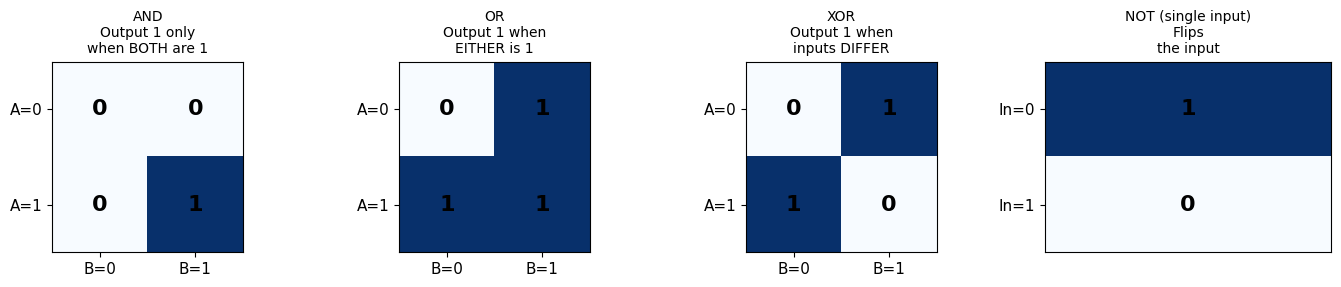

In [8]:
# | export
# Let's visualize all four gates as truth tables
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

gates = [
    ("AND", AND, "Output 1 only\nwhen BOTH are 1"),
    ("OR", OR, "Output 1 when\nEITHER is 1"),
    ("XOR", XOR, "Output 1 when\ninputs DIFFER"),
    ("NOT (single input)", lambda a, b=None: NOT(a), "Flips\nthe input"),
]

for ax, (name, gate, desc) in zip(axes, gates):
    if "NOT" in name:
        # NOT only has one input
        data = [[NOT(0)], [NOT(1)]]
        ax.imshow(data, cmap='Blues', vmin=0, vmax=1, aspect='auto')
        for i, inp in enumerate([0, 1]):
            ax.text(0, i, str(NOT(inp)), ha='center', va='center', fontsize=16, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['In=0', 'In=1'])
    else:
        # 2-input gates
        data = [[gate(a, b) for b in [0, 1]] for a in [0, 1]]
        ax.imshow(data, cmap='Blues', vmin=0, vmax=1)
        for i in range(2):
            for j in range(2):
                ax.text(j, i, str(data[i][j]), ha='center', va='center', fontsize=16, fontweight='bold')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['B=0', 'B=1'])
        ax.set_yticklabels(['A=0', 'A=1'])
    ax.set_title(f"{name}\n{desc}", fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
# Practice: Predict the outputs
test_and_result = AND(1, 0)
test_or_result = OR(0, 0)
test_xor_result = XOR(1, 1)
test_not_result = NOT(0)

# Check your understanding:
assert test_and_result == 0, "AND(1,0) should be 0 - both must be 1"
assert test_or_result == 0, "OR(0,0) should be 0 - neither is 1"
assert test_xor_result == 0, "XOR(1,1) should be 0 - inputs are the same"
assert test_not_result == 1, "NOT(0) should be 1 - flips the input"
print("All gate tests passed!")

All gate tests passed!


## Building an ALU: From Gates to Addition

Now we'll build an actual arithmetic circuit from these gates. The **ALU** (Arithmetic Logic Unit) is the part of your CPU that does math. Let's build one, starting small.

### The Half Adder: Adding Two Bits

A half adder takes two single bits and produces a sum and a carry:

In [10]:
# | export
def half_adder(a, b):
    """
    Add two bits.
    Returns (sum_bit, carry_bit)
    """
    sum_bit = XOR(a, b)   # XOR gives the sum
    carry_bit = AND(a, b)  # AND gives the carry
    return sum_bit, carry_bit

print("Half Adder: adds two bits, produces sum and carry")
print("")
print("  A  B  |  Sum  Carry")
print("  ------+------------")
for a in [0, 1]:
    for b in [0, 1]:
        s, c = half_adder(a, b)
        print(f"  {a}  {b}  |   {s}     {c}")

Half Adder: adds two bits, produces sum and carry

  A  B  |  Sum  Carry
  ------+------------
  0  0  |   0     0
  0  1  |   1     0
  1  0  |   1     0
  1  1  |   0     1


Let's trace through what happens when we add 1 + 1:

In [11]:
input_a = 1
input_b = 1

print(f"Adding {input_a} + {input_b}:")
print(f"")
print(f"  XOR({input_a}, {input_b}) = {XOR(input_a, input_b)}  <- this is our sum bit")
print(f"  AND({input_a}, {input_b}) = {AND(input_a, input_b)}  <- this is our carry bit")
print(f"")
sum_bit, carry_bit = half_adder(input_a, input_b)
print(f"  Result: carry={carry_bit}, sum={sum_bit}")
print(f"  In binary: {carry_bit}{sum_bit} = {carry_bit * 2 + sum_bit} in decimal")

Adding 1 + 1:

  XOR(1, 1) = 0  <- this is our sum bit
  AND(1, 1) = 1  <- this is our carry bit

  Result: carry=1, sum=0
  In binary: 10 = 2 in decimal


### The Full Adder: Handling the Carry

A half adder only works for the rightmost bit. For multi-bit addition, we need to handle a **carry-in** from the previous column.

Think about adding 11 + 01 in binary:
```
    1 1
  + 0 1
  -----
  1 0 0
```

The rightmost column (1+1) produces a carry. The next column must add 1+0 **plus the carry**.

A full adder takes three inputs (A, B, Carry-in) and produces sum + carry-out:

In [12]:
# | export
def full_adder(a, b, carry_in):
    """
    Add two bits plus a carry-in.
    Returns (sum_bit, carry_out)
    """
    # First half-adder: add a + b
    sum1, carry1 = half_adder(a, b)
    
    # Second half-adder: add that result + carry_in
    sum_out, carry2 = half_adder(sum1, carry_in)
    
    # Carry out if EITHER half-adder produced a carry
    carry_out = OR(carry1, carry2)
    
    return sum_out, carry_out

print("Full Adder: adds two bits PLUS a carry-in")
print("")
print("  A  B  Cin |  Sum  Cout")
print("  ---------+-----------")
for a in [0, 1]:
    for b in [0, 1]:
        for c in [0, 1]:
            s, cout = full_adder(a, b, c)
            print(f"  {a}  {b}   {c}  |   {s}     {cout}")

Full Adder: adds two bits PLUS a carry-in

  A  B  Cin |  Sum  Cout
  ---------+-----------
  0  0   0  |   0     0
  0  0   1  |   1     0
  0  1   0  |   1     0
  0  1   1  |   0     1
  1  0   0  |   1     0
  1  0   1  |   0     1
  1  1   0  |   0     1
  1  1   1  |   1     1


### Chaining Full Adders: Multi-Bit Addition

Now we can add larger numbers by chaining full adders together. The carry-out of each column becomes the carry-in of the next:

In [13]:
# | export
def ripple_carry_adder(bits_a, bits_b):
    """
    Add two binary numbers represented as lists of bits.
    bits_a[0] is the least significant bit (rightmost).
    Returns list of sum bits + final carry.
    """
    assert len(bits_a) == len(bits_b), "Numbers must have same number of bits"
    
    result = []
    carry = 0
    
    # Process from least significant to most significant
    for i in range(len(bits_a)):
        sum_bit, carry = full_adder(bits_a[i], bits_b[i], carry)
        result.append(sum_bit)
    
    # Append final carry if present
    if carry:
        result.append(carry)
    
    return result

In [14]:
# Let's add 5 + 3 = 8
# 5 in binary: 101 (bits: [1, 0, 1] from LSB to MSB)
# 3 in binary: 011 (bits: [1, 1, 0] from LSB to MSB)

five_bits = [1, 0, 1]   # 5 = 1*1 + 0*2 + 1*4
three_bits = [1, 1, 0]  # 3 = 1*1 + 1*2 + 0*4

print("Adding 5 + 3 using our ripple-carry adder:")
print(f"")
print(f"  5 in binary: {five_bits[::-1]} (reading left to right)")
print(f"  3 in binary: {three_bits[::-1]} (reading left to right)")

result_bits = ripple_carry_adder(five_bits, three_bits)

print(f"")
print(f"  Result bits: {result_bits[::-1]} (reading left to right)")

# Convert back to decimal
result_decimal = sum(bit * (2 ** i) for i, bit in enumerate(result_bits))
print(f"  Result in decimal: {result_decimal}")

Adding 5 + 3 using our ripple-carry adder:

  5 in binary: [1, 0, 1] (reading left to right)
  3 in binary: [0, 1, 1] (reading left to right)

  Result bits: [1, 0, 0, 0] (reading left to right)
  Result in decimal: 8


In [15]:
# Trace through the addition step by step
def ripple_carry_adder_verbose(bits_a, bits_b):
    print("Step-by-step addition:")
    print("")
    
    result = []
    carry = 0
    
    for i in range(len(bits_a)):
        a, b = bits_a[i], bits_b[i]
        sum_bit, new_carry = full_adder(a, b, carry)
        
        print(f"  Column {i}: {a} + {b} + carry({carry}) = sum:{sum_bit}, carry:{new_carry}")
        
        result.append(sum_bit)
        carry = new_carry
    
    if carry:
        print(f"  Final carry: {carry}")
        result.append(carry)
    
    return result

result = ripple_carry_adder_verbose(five_bits, three_bits)

Step-by-step addition:

  Column 0: 1 + 1 + carry(0) = sum:0, carry:1
  Column 1: 0 + 1 + carry(1) = sum:0, carry:1
  Column 2: 1 + 0 + carry(1) = sum:0, carry:1
  Final carry: 1


### The ALU: A Math Box with an Opcode

Real CPUs don't just add - they can do many operations. The ALU selects which operation to perform based on an **opcode** (operation code).

Let's build a simple ALU that can do four operations:

In [16]:
# | export
def bits_to_int(bits):
    """Convert bits (LSB first) to integer."""
    return sum(bit * (2 ** i) for i, bit in enumerate(bits))

def int_to_bits(n, width):
    """Convert integer to bits (LSB first)."""
    return [(n >> i) & 1 for i in range(width)]

def simple_alu(a_bits, b_bits, opcode):
    """
    A simple 4-bit ALU.
    Opcodes:
      00 = AND (bitwise)
      01 = OR (bitwise)
      10 = ADD
      11 = XOR (bitwise)
    """
    result = []
    
    if opcode == 0b00:  # AND
        result = [AND(a, b) for a, b in zip(a_bits, b_bits)]
        op_name = "AND"
    elif opcode == 0b01:  # OR
        result = [OR(a, b) for a, b in zip(a_bits, b_bits)]
        op_name = "OR"
    elif opcode == 0b10:  # ADD
        result = ripple_carry_adder(a_bits, b_bits)
        op_name = "ADD"
    elif opcode == 0b11:  # XOR
        result = [XOR(a, b) for a, b in zip(a_bits, b_bits)]
        op_name = "XOR"
    
    return result, op_name

# Demo the ALU
a_bits = int_to_bits(5, 4)  # 5 = 0101
b_bits = int_to_bits(3, 4)  # 3 = 0011

print(f"ALU inputs: A = 5 (bits: {a_bits[::-1]}), B = 3 (bits: {b_bits[::-1]})")
print("")

for opcode in [0b00, 0b01, 0b10, 0b11]:
    result, op_name = simple_alu(a_bits, b_bits, opcode)
    result_int = bits_to_int(result)
    print(f"  Opcode {opcode:02b} ({op_name}): {result[::-1]} = {result_int}")

ALU inputs: A = 5 (bits: [0, 1, 0, 1]), B = 3 (bits: [0, 0, 1, 1])

  Opcode 00 (AND): [0, 0, 0, 1] = 1
  Opcode 01 (OR): [0, 1, 1, 1] = 7
  Opcode 10 (ADD): [1, 0, 0, 0] = 8
  Opcode 11 (XOR): [0, 1, 1, 0] = 6


In [17]:
# Practice: Use the ALU
test_a = int_to_bits(12, 4)  # 1100 in binary
test_b = int_to_bits(10, 4)  # 1010 in binary

# What is 12 AND 10?
test_and_result, _ = simple_alu(test_a, test_b, 0b00)
assert bits_to_int(test_and_result) == 8, "12 AND 10 = 8 (only bit 3 is 1 in both)"

# What is 12 XOR 10?
test_xor_result, _ = simple_alu(test_a, test_b, 0b11)
assert bits_to_int(test_xor_result) == 6, "12 XOR 10 = 6 (bits differ at positions 1 and 2)"

print("ALU tests passed!")
print(f"  12 AND 10 = {bits_to_int(test_and_result)}")
print(f"  12 XOR 10 = {bits_to_int(test_xor_result)}")

ALU tests passed!
  12 AND 10 = 8
  12 XOR 10 = 6


## Clock Cycles: The Heartbeat of a CPU

So far we've built circuits that compute instantly (in our simulation). But real CPUs work in discrete time steps called **clock cycles**.

Think of the clock as a metronome: tick, tick, tick. On each tick, the CPU can do one "thing" - fetch an instruction, decode it, execute it, etc.

### Why Cycles Matter

A 3 GHz CPU has 3 billion cycles per second. Each cycle is about 0.33 nanoseconds.

Different operations take different numbers of cycles:
- Simple ALU operation (add, and, or): ~1 cycle
- Multiplication: ~3-5 cycles
- Division: ~10-40 cycles
- Memory access: varies wildly (more on this soon)

Let's simulate a tiny CPU that counts cycles:

In [18]:
# | export
class TinyCPU:
    """
    A minimal CPU simulator that counts cycles.
    Has 4 registers (R0-R3) and tracks cycle count.
    """
    def __init__(self):
        self.registers = [0, 0, 0, 0]  # R0, R1, R2, R3
        self.cycle_count = 0
    
    def load_immediate(self, reg, value):
        """Load a constant value into a register. (1 cycle)"""
        self.registers[reg] = value
        self.cycle_count += 1
        return f"LOAD R{reg}, {value}"
    
    def add(self, dest, src1, src2):
        """Add two registers, store in dest. (1 cycle)"""
        self.registers[dest] = self.registers[src1] + self.registers[src2]
        self.cycle_count += 1
        return f"ADD R{dest}, R{src1}, R{src2}"
    
    def multiply(self, dest, src1, src2):
        """Multiply two registers, store in dest. (3 cycles)"""
        self.registers[dest] = self.registers[src1] * self.registers[src2]
        self.cycle_count += 3  # Multiplication is slower!
        return f"MUL R{dest}, R{src1}, R{src2}"
    
    def status(self):
        regs = ", ".join(f"R{i}={v}" for i, v in enumerate(self.registers))
        return f"[Cycle {self.cycle_count}] {regs}"

In [19]:
# Let's compute 5 * 3 + 7
cpu = TinyCPU()

print("Program: compute 5 * 3 + 7")
print("")
print(cpu.status())
print("")

# Load values
instr = cpu.load_immediate(0, 5)
print(f"  {instr}")
print(f"    {cpu.status()}")

instr = cpu.load_immediate(1, 3)
print(f"  {instr}")
print(f"    {cpu.status()}")

instr = cpu.load_immediate(2, 7)
print(f"  {instr}")
print(f"    {cpu.status()}")

# Multiply 5 * 3
instr = cpu.multiply(3, 0, 1)  # R3 = R0 * R1
print(f"  {instr}")
print(f"    {cpu.status()}")

# Add 7
instr = cpu.add(3, 3, 2)  # R3 = R3 + R2
print(f"  {instr}")
print(f"    {cpu.status()}")

print(f"")
print(f"Final result: R3 = {cpu.registers[3]}")
print(f"Total cycles: {cpu.cycle_count}")

Program: compute 5 * 3 + 7

[Cycle 0] R0=0, R1=0, R2=0, R3=0

  LOAD R0, 5
    [Cycle 1] R0=5, R1=0, R2=0, R3=0
  LOAD R1, 3
    [Cycle 2] R0=5, R1=3, R2=0, R3=0
  LOAD R2, 7
    [Cycle 3] R0=5, R1=3, R2=7, R3=0
  MUL R3, R0, R1
    [Cycle 6] R0=5, R1=3, R2=7, R3=15
  ADD R3, R3, R2
    [Cycle 7] R0=5, R1=3, R2=7, R3=22

Final result: R3 = 22
Total cycles: 7


Notice how the multiply instruction took 3 cycles while add took only 1. This is why performance-sensitive code sometimes avoids expensive operations.

In [20]:
# Compare: 8 * x vs x + x + x + x + x + x + x + x
# (In real CPUs, shifts would be even faster, but let's compare add vs multiply)

def compute_with_multiply(x):
    cpu = TinyCPU()
    cpu.load_immediate(0, x)
    cpu.load_immediate(1, 8)
    cpu.multiply(2, 0, 1)
    return cpu.registers[2], cpu.cycle_count

def compute_with_adds(x):
    cpu = TinyCPU()
    cpu.load_immediate(0, x)
    cpu.load_immediate(1, 0)  # accumulator
    for _ in range(8):
        cpu.add(1, 1, 0)  # accumulator += x
    return cpu.registers[1], cpu.cycle_count

x = 7
result_mul, cycles_mul = compute_with_multiply(x)
result_add, cycles_add = compute_with_adds(x)

print(f"Computing 8 * {x}:")
print(f"")
print(f"  Using multiply: result={result_mul}, cycles={cycles_mul}")
print(f"  Using 8 adds:   result={result_add}, cycles={cycles_add}")
print(f"")
print(f"  Multiply is faster by {cycles_add - cycles_mul} cycles!")

Computing 8 * 7:

  Using multiply: result=56, cycles=5
  Using 8 adds:   result=56, cycles=10

  Multiply is faster by 5 cycles!


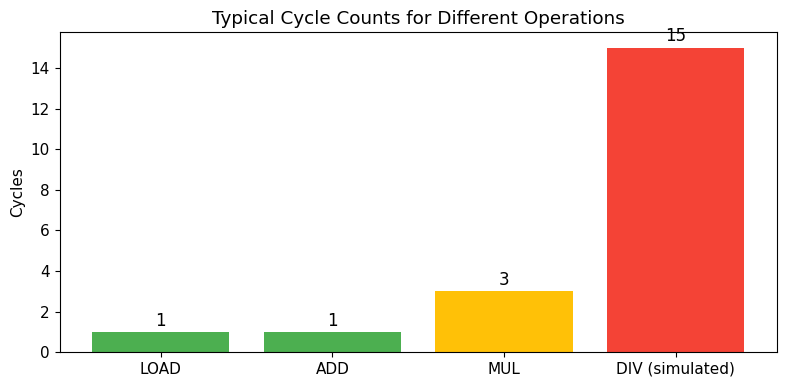

Key insight: not all operations are created equal!
Division can be 15x slower than addition.


In [21]:
# Visualize cycle count for different operations
operations = ['LOAD', 'ADD', 'MUL', 'DIV (simulated)']
cycles = [1, 1, 3, 15]  # Typical cycle counts

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(operations, cycles, color=['#4CAF50', '#4CAF50', '#FFC107', '#F44336'])
ax.set_ylabel('Cycles')
ax.set_title('Typical Cycle Counts for Different Operations')

# Add value labels on bars
for bar, cycle in zip(bars, cycles):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            str(cycle), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print("Key insight: not all operations are created equal!")
print("Division can be 15x slower than addition.")

### The Fetch-Decode-Execute Cycle: How It All Fits Together

Before we move on, let's see how the pieces we've built connect. Every instruction your CPU runs follows a simple loop called the **fetch-decode-execute cycle**:

```
    +------------------+
    |                  |
    v                  |
+--------+    +--------+    +---------+    +---------+
| FETCH  | -> | DECODE | -> | EXECUTE | -> | WRITEBACK|--+
+--------+    +--------+    +---------+    +---------+
    |              |             |              |
    |              |             |              |
 Read the      Figure out     Do the work    Store the
 next          what the       (use ALU,      result
 instruction   instruction    access         back
 from memory   means          memory)
```

1. **FETCH**: The CPU reads the next instruction from memory (using the Program Counter)
2. **DECODE**: A component called the **Control Unit** figures out what the instruction means and what opcode to send to the ALU
3. **EXECUTE**: The ALU does the actual computation
4. **WRITEBACK**: Results go back to registers (or memory)

This happens billions of times per second. Each cycle through this loop typically takes 1 clock tick for simple instructions.

The key insight: **most of the work isn't math - it's shuffling data around**. The ALU (execute phase) is blazingly fast. The bottleneck is getting data to and from it.

## Memory Hierarchy: Why Speed Has Layers

We just saw that the ALU can do billions of operations per second. Additions take 1 cycle. Even division only takes ~15 cycles. So why doesn't your code run instantly?

**The problem: the ALU is starving for data.**

Think about it: before the ALU can add two numbers, those numbers must be loaded into registers. After it computes a result, that result must be stored somewhere. The ALU itself is fast - but waiting for data is slow.

This brings us to the central question of computer architecture: **how do we feed the ALU fast enough?**

Here's a question: if we have fast registers in the CPU, why not just make them bigger? Why have RAM at all?

The answer is **physics**: fast memory is expensive and physically large (per bit). There's a fundamental tradeoff:

- **Fast** memory = expensive, small capacity
- **Big** memory = cheap, but slow

This is why computers have a **memory hierarchy** - multiple levels of memory with different speed/size tradeoffs.

In [22]:
# | export
# Real-world numbers (approximate, varies by CPU)
memory_hierarchy = {
    'Registers': {
        'size_bytes': 64 * 8,           # ~64 registers, 8 bytes each
        'access_time_ns': 0.5,          # Sub-nanosecond
        'description': 'Inside CPU core'
    },
    'L1 Cache': {
        'size_bytes': 32 * 1024,        # 32 KB typical
        'access_time_ns': 1,            # ~1 ns
        'description': 'Per-core, split I/D'
    },
    'L2 Cache': {
        'size_bytes': 256 * 1024,       # 256 KB typical
        'access_time_ns': 4,            # ~4 ns
        'description': 'Per-core'
    },
    'L3 Cache': {
        'size_bytes': 8 * 1024 * 1024,  # 8 MB typical
        'access_time_ns': 12,           # ~12 ns
        'description': 'Shared across cores'
    },
    'RAM (DDR4)': {
        'size_bytes': 16 * 1024 * 1024 * 1024,  # 16 GB
        'access_time_ns': 80,           # ~80 ns
        'description': 'Main memory'
    },
    'SSD': {
        'size_bytes': 512 * 1024 * 1024 * 1024,  # 512 GB
        'access_time_ns': 100_000,      # ~100 microseconds
        'description': 'Persistent storage'
    }
}

print("Memory Hierarchy: Speed vs Size Tradeoff")
print("")
print(f"{'Level':<12} {'Size':<12} {'Access Time':<15} {'Notes'}")
print("-" * 65)

for level, info in memory_hierarchy.items():
    size = info['size_bytes']
    if size >= 1024**3:
        size_str = f"{size / 1024**3:.0f} GB"
    elif size >= 1024**2:
        size_str = f"{size / 1024**2:.0f} MB"
    elif size >= 1024:
        size_str = f"{size / 1024:.0f} KB"
    else:
        size_str = f"{size} B"
    
    time = info['access_time_ns']
    if time >= 1000:
        time_str = f"{time/1000:.0f} us"
    else:
        time_str = f"{time:.1f} ns"
    
    print(f"{level:<12} {size_str:<12} {time_str:<15} {info['description']}")

Memory Hierarchy: Speed vs Size Tradeoff

Level        Size         Access Time     Notes
-----------------------------------------------------------------
Registers    512 B        0.5 ns          Inside CPU core
L1 Cache     32 KB        1.0 ns          Per-core, split I/D
L2 Cache     256 KB       4.0 ns          Per-core
L3 Cache     8 MB         12.0 ns         Shared across cores
RAM (DDR4)   16 GB        80.0 ns         Main memory
SSD          512 GB       100 us          Persistent storage


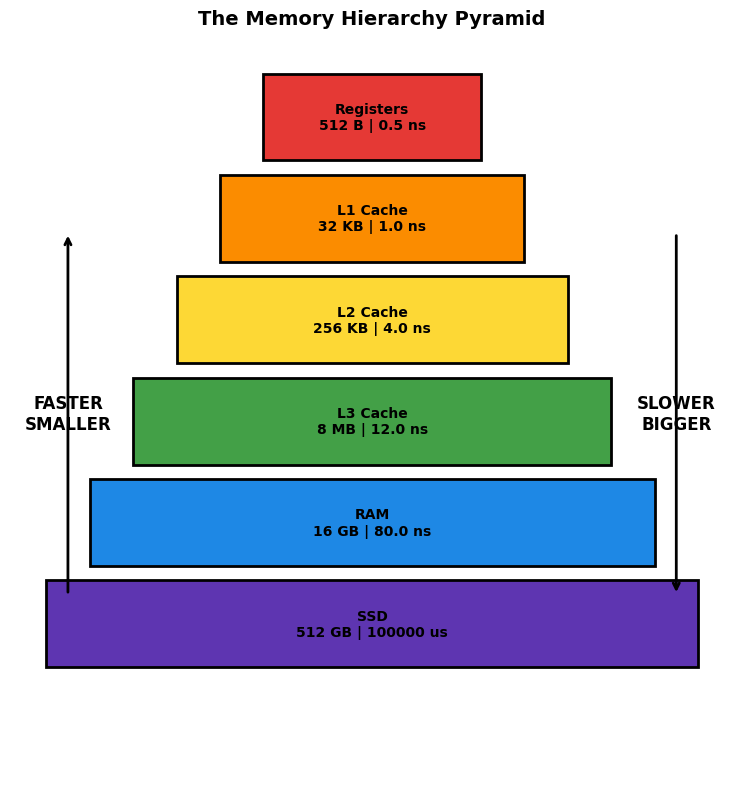

In [23]:
# | export
# Visualize as a pyramid (the classic memory hierarchy diagram)
fig, ax = plt.subplots(figsize=(12, 8))

levels = ['Registers', 'L1 Cache', 'L2 Cache', 'L3 Cache', 'RAM', 'SSD']
times = [0.5, 1, 4, 12, 80, 100_000]
sizes_gb = [64*8/1e9, 32e3/1e9, 256e3/1e9, 8e6/1e9, 16, 512]

# Draw pyramid layers
colors = ['#E53935', '#FB8C00', '#FDD835', '#43A047', '#1E88E5', '#5E35B1']
n = len(levels)

for i, (level, time, size, color) in enumerate(zip(levels, times, sizes_gb, colors)):
    # Width increases as we go down
    width = 0.3 + i * 0.12
    height = 0.12
    y = 0.85 - i * 0.14
    
    # Draw trapezoid-ish shape
    rect = plt.Rectangle((0.5 - width/2, y), width, height, 
                          facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    
    # Add label
    time_str = f"{time:.0f} us" if time >= 1000 else f"{time:.1f} ns"
    size_str = f"{size*1000:.0f} MB" if size < 1 else f"{size:.0f} GB"
    if size < 0.001:
        size_str = f"{size*1e6:.0f} KB" if size*1e6 >= 1 else f"{size*1e9:.0f} B"
    
    ax.text(0.5, y + height/2, f"{level}\n{size_str} | {time_str}", 
            ha='center', va='center', fontsize=10, fontweight='bold')

# Labels
ax.text(0.08, 0.5, 'FASTER\nSMALLER', ha='center', va='center', fontsize=12, fontweight='bold')
ax.annotate('', xy=(0.08, 0.75), xytext=(0.08, 0.25),
            arrowprops=dict(arrowstyle='->', lw=2))

ax.text(0.92, 0.5, 'SLOWER\nBIGGER', ha='center', va='center', fontsize=12, fontweight='bold')
ax.annotate('', xy=(0.92, 0.25), xytext=(0.92, 0.75),
            arrowprops=dict(arrowstyle='->', lw=2))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('The Memory Hierarchy Pyramid', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [24]:
# Let's make this concrete: how much slower is RAM vs registers?
reg_time = 0.5   # ns
ram_time = 80    # ns

slowdown = ram_time / reg_time

print(f"RAM is {slowdown:.0f}x slower than registers!")
print("")
print("In human terms:")
print(f"  If register access = 1 second")
print(f"  Then RAM access = {slowdown:.0f} seconds ({slowdown/60:.1f} minutes)")
print("")
print("And SSD?")
ssd_time = 100_000  # ns
ssd_slowdown = ssd_time / reg_time
print(f"  SSD is {ssd_slowdown:,.0f}x slower than registers")
print(f"  If register = 1 second, SSD = {ssd_slowdown/3600:.0f} hours")

RAM is 160x slower than registers!

In human terms:
  If register access = 1 second
  Then RAM access = 160 seconds (2.7 minutes)

And SSD?
  SSD is 200,000x slower than registers
  If register = 1 second, SSD = 56 hours


### The Cache: Automatic Speed Optimization

The cache sits between the CPU and RAM, automatically storing recently-used data. When you access memory:

1. CPU checks L1 cache first (~1 ns)
2. If not there ("cache miss"), check L2 (~4 ns)
3. If not there, check L3 (~12 ns)
4. If not there, go to RAM (~80 ns)

This works because of **locality**: programs tend to access the same memory locations repeatedly (temporal locality) or access nearby locations (spatial locality).

In [25]:
# | export
class MemorySystem:
    """
    Simulates a memory hierarchy with cache.
    """
    def __init__(self, cache_size=4):
        self.ram = {}  # Address -> Value
        self.cache = {}  # Address -> Value (LRU, limited size)
        self.cache_size = cache_size
        self.cache_order = []  # For LRU tracking
        
        self.stats = {
            'cache_hits': 0,
            'cache_misses': 0,
            'total_cycles': 0
        }
        
        # Timing (in cycles, not ns, for simplicity)
        self.cache_latency = 1
        self.ram_latency = 10
    
    def write_ram(self, address, value):
        """Write directly to RAM (initialization)."""
        self.ram[address] = value
    
    def read(self, address):
        """Read from memory (goes through cache)."""
        if address in self.cache:
            # Cache hit!
            self.stats['cache_hits'] += 1
            self.stats['total_cycles'] += self.cache_latency
            # Update LRU order
            self.cache_order.remove(address)
            self.cache_order.append(address)
            return self.cache[address], 'HIT'
        else:
            # Cache miss - fetch from RAM
            self.stats['cache_misses'] += 1
            self.stats['total_cycles'] += self.ram_latency
            
            value = self.ram.get(address, 0)
            
            # Add to cache (evict LRU if full)
            if len(self.cache) >= self.cache_size:
                evict_addr = self.cache_order.pop(0)
                del self.cache[evict_addr]
            
            self.cache[address] = value
            self.cache_order.append(address)
            
            return value, 'MISS'
    
    def report(self):
        total = self.stats['cache_hits'] + self.stats['cache_misses']
        hit_rate = self.stats['cache_hits'] / total if total > 0 else 0
        return {
            'hit_rate': hit_rate,
            'total_accesses': total,
            'total_cycles': self.stats['total_cycles']
        }

In [26]:
# Demo: accessing memory with good locality
mem = MemorySystem(cache_size=4)

# Initialize some data in RAM
for addr in range(10):
    mem.write_ram(addr, addr * 10)  # Address 0 has 0, address 1 has 10, etc.

print("Accessing memory with GOOD locality (same addresses repeatedly):")
print("")

# Access pattern: 0, 1, 2, 0, 1, 2, 0, 1, 2
addresses_good = [0, 1, 2, 0, 1, 2, 0, 1, 2]

for addr in addresses_good:
    value, status = mem.read(addr)
    print(f"  Read address {addr}: value={value}, {status}")

report = mem.report()
print(f"")
print(f"Results:")
print(f"  Hit rate: {report['hit_rate']*100:.0f}%")
print(f"  Total cycles: {report['total_cycles']}")

Accessing memory with GOOD locality (same addresses repeatedly):

  Read address 0: value=0, MISS
  Read address 1: value=10, MISS
  Read address 2: value=20, MISS
  Read address 0: value=0, HIT
  Read address 1: value=10, HIT
  Read address 2: value=20, HIT
  Read address 0: value=0, HIT
  Read address 1: value=10, HIT
  Read address 2: value=20, HIT

Results:
  Hit rate: 67%
  Total cycles: 36


In [27]:
# Demo: accessing memory with BAD locality
mem_bad = MemorySystem(cache_size=4)

# Initialize some data in RAM
for addr in range(10):
    mem_bad.write_ram(addr, addr * 10)

print("Accessing memory with BAD locality (always different addresses):")
print("")

# Access pattern: 0, 1, 2, 3, 4, 5, 6, 7, 8 (cache can only hold 4)
addresses_bad = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for addr in addresses_bad:
    value, status = mem_bad.read(addr)
    print(f"  Read address {addr}: value={value}, {status}")

report_bad = mem_bad.report()
print(f"")
print(f"Results:")
print(f"  Hit rate: {report_bad['hit_rate']*100:.0f}%")
print(f"  Total cycles: {report_bad['total_cycles']}")

Accessing memory with BAD locality (always different addresses):

  Read address 0: value=0, MISS
  Read address 1: value=10, MISS
  Read address 2: value=20, MISS
  Read address 3: value=30, MISS
  Read address 4: value=40, MISS
  Read address 5: value=50, MISS
  Read address 6: value=60, MISS
  Read address 7: value=70, MISS
  Read address 8: value=80, MISS

Results:
  Hit rate: 0%
  Total cycles: 90


In [28]:
# Compare the two
print("Comparison:")
print(f"")
print(f"  Good locality: {report['total_cycles']} cycles, {report['hit_rate']*100:.0f}% hit rate")
print(f"  Bad locality:  {report_bad['total_cycles']} cycles, {report_bad['hit_rate']*100:.0f}% hit rate")
print(f"")
print(f"  Bad locality is {report_bad['total_cycles'] / report['total_cycles']:.1f}x slower!")
print(f"")
print("This is why cache-friendly code matters so much for performance.")

Comparison:

  Good locality: 36 cycles, 67% hit rate
  Bad locality:  90 cycles, 0% hit rate

  Bad locality is 2.5x slower!

This is why cache-friendly code matters so much for performance.


## Load and Store: Moving Data Around

The CPU can only compute on data in registers. Everything else must be **loaded** from memory first, and results must be **stored** back.

This is called the **load/store architecture** and it's how most modern CPUs work:

1. **LOAD**: Copy data from memory into a register
2. **Compute**: Do math on registers (using the ALU)
3. **STORE**: Copy result from register back to memory

In [29]:
# | export
class LoadStoreCPU:
    """
    A CPU that models load/store operations explicitly.
    """
    def __init__(self):
        self.registers = [0] * 4  # R0-R3
        self.memory = [0] * 16    # 16 memory locations
        self.cycles = 0
        
        # Timing
        self.reg_op_cycles = 1      # Register-to-register ops
        self.load_cycles = 10       # Memory to register
        self.store_cycles = 10      # Register to memory
    
    def load(self, reg, mem_addr):
        """Load from memory[mem_addr] into registers[reg]."""
        self.registers[reg] = self.memory[mem_addr]
        self.cycles += self.load_cycles
        return f"LOAD R{reg}, mem[{mem_addr}]  -> R{reg}={self.registers[reg]}"
    
    def store(self, reg, mem_addr):
        """Store registers[reg] into memory[mem_addr]."""
        self.memory[mem_addr] = self.registers[reg]
        self.cycles += self.store_cycles
        return f"STORE R{reg}, mem[{mem_addr}]  -> mem[{mem_addr}]={self.memory[mem_addr]}"
    
    def add_reg(self, dest, src1, src2):
        """Add two registers."""
        self.registers[dest] = self.registers[src1] + self.registers[src2]
        self.cycles += self.reg_op_cycles
        return f"ADD R{dest}, R{src1}, R{src2}  -> R{dest}={self.registers[dest]}"
    
    def mul_reg(self, dest, src1, src2):
        """Multiply two registers."""
        self.registers[dest] = self.registers[src1] * self.registers[src2]
        self.cycles += self.reg_op_cycles * 3  # Multiply takes longer
        return f"MUL R{dest}, R{src1}, R{src2}  -> R{dest}={self.registers[dest]}"

In [30]:
# Example: Compute A[0] + A[1] and store in A[2]
cpu = LoadStoreCPU()

# Initialize memory (like an array A)
cpu.memory[0] = 5   # A[0] = 5
cpu.memory[1] = 3   # A[1] = 3
cpu.memory[2] = 0   # A[2] = 0 (will hold result)

print("Task: Compute A[0] + A[1] and store in A[2]")
print(f"Initial: A = {cpu.memory[:3]}")
print("")

# Step 1: Load A[0] into R0
print(f"  {cpu.load(0, 0)}")
print(f"    Cycles so far: {cpu.cycles}")

# Step 2: Load A[1] into R1
print(f"  {cpu.load(1, 1)}")
print(f"    Cycles so far: {cpu.cycles}")

# Step 3: Add R0 + R1, store in R2
print(f"  {cpu.add_reg(2, 0, 1)}")
print(f"    Cycles so far: {cpu.cycles}")

# Step 4: Store R2 to A[2]
print(f"  {cpu.store(2, 2)}")
print(f"    Cycles so far: {cpu.cycles}")

print(f"")
print(f"Final: A = {cpu.memory[:3]}")
print(f"Total cycles: {cpu.cycles}")

Task: Compute A[0] + A[1] and store in A[2]
Initial: A = [5, 3, 0]

  LOAD R0, mem[0]  -> R0=5
    Cycles so far: 10
  LOAD R1, mem[1]  -> R1=3
    Cycles so far: 20
  ADD R2, R0, R1  -> R2=8
    Cycles so far: 21
  STORE R2, mem[2]  -> mem[2]=8
    Cycles so far: 31

Final: A = [5, 3, 8]
Total cycles: 31


In [ ]:
# Break down where time goes IN OUR TOY MODEL
# (Real CPUs have caches that can hide some of this latency)
load_time = 20    # 2 loads * 10 cycles each
compute_time = 1  # 1 add * 1 cycle
store_time = 10   # 1 store * 10 cycles
total = load_time + compute_time + store_time

print("Where did the time go? (in our simplified model)")
print(f"")
print(f"  Loading data:   {load_time} cycles ({100*load_time/total:.0f}%)")
print(f"  Computation:    {compute_time} cycles ({100*compute_time/total:.0f}%)")
print(f"  Storing result: {store_time} cycles ({100*store_time/total:.0f}%)")
print(f"")
print(f"In this example, only {100*compute_time/total:.0f}% of time is actual computation!")
print("")
print("This is a simplified model, but the insight is real:")
print("Memory access often dominates. The actual math is the easy part.")
print("")
print("In practice, caches help a lot - but the pattern holds:")
print("  - Uncached memory access: ~100 cycles")
print("  - Simple ALU operation: ~1 cycle")
print("  - Ratio: memory can be 100x slower than compute")

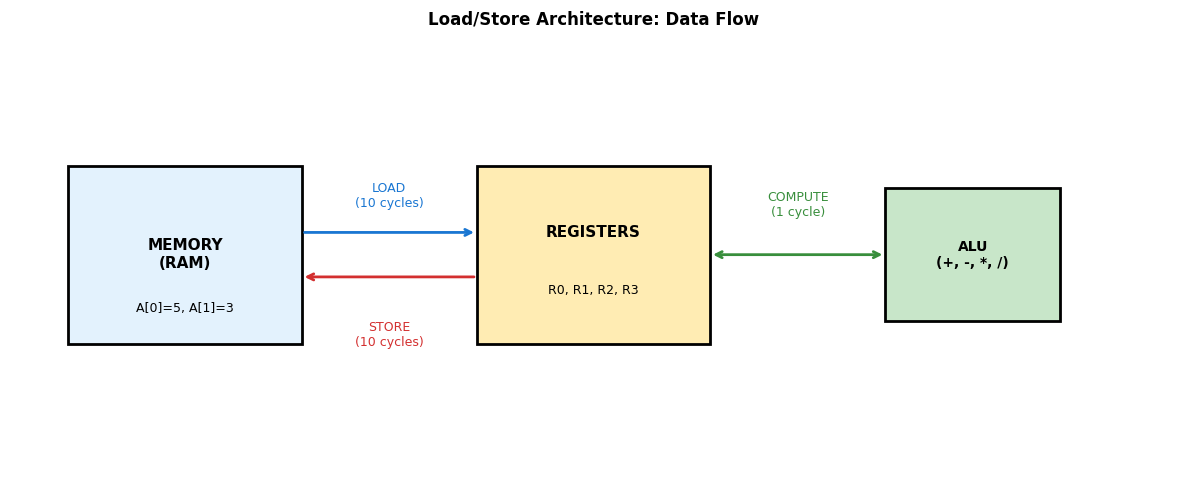

In [32]:
# | export
# Visualize the data flow
fig, ax = plt.subplots(figsize=(12, 5))

# Draw components
# Memory on the left
mem_box = plt.Rectangle((0.05, 0.3), 0.2, 0.4, facecolor='#E3F2FD', edgecolor='black', linewidth=2)
ax.add_patch(mem_box)
ax.text(0.15, 0.5, 'MEMORY\n(RAM)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(0.15, 0.38, 'A[0]=5, A[1]=3', ha='center', va='center', fontsize=9)

# Registers in the middle
reg_box = plt.Rectangle((0.4, 0.3), 0.2, 0.4, facecolor='#FFECB3', edgecolor='black', linewidth=2)
ax.add_patch(reg_box)
ax.text(0.5, 0.55, 'REGISTERS', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(0.5, 0.42, 'R0, R1, R2, R3', ha='center', va='center', fontsize=9)

# ALU on the right
alu_box = plt.Rectangle((0.75, 0.35), 0.15, 0.3, facecolor='#C8E6C9', edgecolor='black', linewidth=2)
ax.add_patch(alu_box)
ax.text(0.825, 0.5, 'ALU\n(+, -, *, /)', ha='center', va='center', fontsize=10, fontweight='bold')

# Arrows
# Load arrow (Memory -> Registers)
ax.annotate('', xy=(0.4, 0.55), xytext=(0.25, 0.55),
            arrowprops=dict(arrowstyle='->', color='#1976D2', lw=2))
ax.text(0.325, 0.6, 'LOAD\n(10 cycles)', ha='center', va='bottom', fontsize=9, color='#1976D2')

# Store arrow (Registers -> Memory)
ax.annotate('', xy=(0.25, 0.45), xytext=(0.4, 0.45),
            arrowprops=dict(arrowstyle='->', color='#D32F2F', lw=2))
ax.text(0.325, 0.35, 'STORE\n(10 cycles)', ha='center', va='top', fontsize=9, color='#D32F2F')

# Compute arrow (Registers <-> ALU)
ax.annotate('', xy=(0.75, 0.5), xytext=(0.6, 0.5),
            arrowprops=dict(arrowstyle='<->', color='#388E3C', lw=2))
ax.text(0.675, 0.58, 'COMPUTE\n(1 cycle)', ha='center', va='bottom', fontsize=9, color='#388E3C')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Load/Store Architecture: Data Flow', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Flow Control: Branches and Jumps

So far our programs have been linear: do instruction 1, then 2, then 3. But real programs have conditionals (if/else) and loops. How does the CPU handle these?

The answer: **jumps**. The CPU has a **program counter** (PC) that points to the current instruction. Normally it increments by 1 after each instruction. But special instructions can set it to a different value:

- **Jump**: Always go to address X
- **Branch**: Go to address X if some condition is true

In [33]:
# | export
class ProgrammableCPU:
    """
    A CPU that executes a program with jumps and branches.
    """
    def __init__(self):
        self.registers = [0] * 4
        self.pc = 0  # Program counter
        self.program = []
        self.cycles = 0
        self.halted = False
        self.trace = []
    
    def load_program(self, program):
        """Load a list of instructions."""
        self.program = program
        self.pc = 0
        self.halted = False
        self.trace = []
    
    def step(self):
        """Execute one instruction."""
        if self.halted or self.pc >= len(self.program):
            self.halted = True
            return None
        
        instr = self.program[self.pc]
        op = instr[0]
        
        self.trace.append(f"PC={self.pc}: {instr}")
        
        if op == 'LOAD_IMM':
            # LOAD_IMM reg, value
            self.registers[instr[1]] = instr[2]
            self.cycles += 1
            self.pc += 1
        
        elif op == 'ADD':
            # ADD dest, src1, src2
            self.registers[instr[1]] = self.registers[instr[2]] + self.registers[instr[3]]
            self.cycles += 1
            self.pc += 1
        
        elif op == 'SUB':
            # SUB dest, src1, src2
            self.registers[instr[1]] = self.registers[instr[2]] - self.registers[instr[3]]
            self.cycles += 1
            self.pc += 1
        
        elif op == 'JUMP':
            # JUMP target_pc
            self.pc = instr[1]
            self.cycles += 1
        
        elif op == 'BRANCH_GT_ZERO':
            # BRANCH_GT_ZERO reg, target_pc (branch if reg > 0)
            if self.registers[instr[1]] > 0:
                self.pc = instr[2]
                self.trace[-1] += " -> TAKEN"
            else:
                self.pc += 1
                self.trace[-1] += " -> NOT TAKEN"
            self.cycles += 1
        
        elif op == 'HALT':
            self.halted = True
            self.cycles += 1
        
        return instr
    
    def run(self, max_steps=100):
        """Run until halted or max_steps reached."""
        steps = 0
        while not self.halted and steps < max_steps:
            self.step()
            steps += 1
        return steps

In [34]:
# Example: A simple loop that counts down from 5 to 0
# while (R0 > 0) { R0 = R0 - 1 }

countdown_program = [
    ('LOAD_IMM', 0, 5),          # 0: R0 = 5
    ('LOAD_IMM', 1, 1),          # 1: R1 = 1 (for subtraction)
    # Loop starts here (PC = 2)
    ('SUB', 0, 0, 1),            # 2: R0 = R0 - R1
    ('BRANCH_GT_ZERO', 0, 2),    # 3: If R0 > 0, jump back to PC=2
    ('HALT',),                   # 4: Stop
]

cpu = ProgrammableCPU()
cpu.load_program(countdown_program)

print("Program: Count down from 5 to 0")
print("")
print("Instructions:")
for i, instr in enumerate(countdown_program):
    print(f"  {i}: {instr}")
print("")

steps = cpu.run()

print("Execution trace:")
for t in cpu.trace:
    print(f"  {t}")

print(f"")
print(f"Final R0 = {cpu.registers[0]}")
print(f"Total cycles: {cpu.cycles}")

Program: Count down from 5 to 0

Instructions:
  0: ('LOAD_IMM', 0, 5)
  1: ('LOAD_IMM', 1, 1)
  2: ('SUB', 0, 0, 1)
  3: ('BRANCH_GT_ZERO', 0, 2)
  4: ('HALT',)

Execution trace:
  PC=0: ('LOAD_IMM', 0, 5)
  PC=1: ('LOAD_IMM', 1, 1)
  PC=2: ('SUB', 0, 0, 1)
  PC=3: ('BRANCH_GT_ZERO', 0, 2) -> TAKEN
  PC=2: ('SUB', 0, 0, 1)
  PC=3: ('BRANCH_GT_ZERO', 0, 2) -> TAKEN
  PC=2: ('SUB', 0, 0, 1)
  PC=3: ('BRANCH_GT_ZERO', 0, 2) -> TAKEN
  PC=2: ('SUB', 0, 0, 1)
  PC=3: ('BRANCH_GT_ZERO', 0, 2) -> TAKEN
  PC=2: ('SUB', 0, 0, 1)
  PC=3: ('BRANCH_GT_ZERO', 0, 2) -> NOT TAKEN
  PC=4: ('HALT',)

Final R0 = 0
Total cycles: 13


### Pipelining: Why Branches are "Expensive"

To understand why branches hurt performance, we first need to understand **pipelining**.

Think about doing laundry. You could:
- **Without pipelining**: Wash load 1, dry load 1, fold load 1. Then wash load 2, dry load 2, fold load 2.
- **With pipelining**: Start washing load 2 while load 1 is drying. Start washing load 3 while load 2 is drying and load 1 is being folded.

Pipelining lets you overlap work. Modern CPUs do the same thing with instructions: while one instruction is being executed, the next one is being decoded, and the one after that is being fetched from memory.

```
Time ->   1    2    3    4    5    6
Instr 1: [FETCH][DECODE][EXECUTE]
Instr 2:       [FETCH][DECODE][EXECUTE]
Instr 3:              [FETCH][DECODE][EXECUTE]
```

This works great for linear code. But what about branches?

**The problem**: when the CPU is executing a branch instruction, it has already fetched and started decoding the next instruction. But if the branch is taken, that "next instruction" was the wrong one!

The CPU must throw away that work - a **pipeline stall**. CPUs use **branch prediction** to guess which way a branch will go. If the guess is right, no stall. If wrong, wasted cycles.

Common patterns (like loops that usually repeat) are predicted well. Random branches are predicted poorly.

In [35]:
# Simulate branch prediction
import random

class BranchPredictor:
    """
    A simple branch predictor.
    Predicts that branches will go the same way they went last time.
    """
    def __init__(self):
        self.history = {}  # branch_id -> last outcome
        self.correct = 0
        self.total = 0
    
    def predict(self, branch_id):
        # If we've seen this branch, predict same as last time
        # Otherwise, predict taken (loops usually repeat)
        return self.history.get(branch_id, True)
    
    def update(self, branch_id, actual):
        prediction = self.predict(branch_id)
        self.total += 1
        if prediction == actual:
            self.correct += 1
        self.history[branch_id] = actual
    
    def accuracy(self):
        return self.correct / self.total if self.total > 0 else 0

# Test with a predictable pattern (loop)
predictor_loop = BranchPredictor()
loop_pattern = [True] * 9 + [False]  # Loop 9 times, then exit (like countdown)

for _ in range(5):  # 5 outer iterations
    for outcome in loop_pattern:
        predictor_loop.update('loop_branch', outcome)

print("Branch prediction accuracy:")
print(f"")
print(f"  Predictable loop pattern: {predictor_loop.accuracy()*100:.0f}% accuracy")

# Test with random pattern
predictor_random = BranchPredictor()
random_pattern = [random.choice([True, False]) for _ in range(50)]

for outcome in random_pattern:
    predictor_random.update('random_branch', outcome)

print(f"  Random/unpredictable:     {predictor_random.accuracy()*100:.0f}% accuracy")
print("")
print("When prediction fails, the CPU wastes cycles on work it has to discard.")
print("This is why predictable code patterns run faster.")

Branch prediction accuracy:

  Predictable loop pattern: 82% accuracy
  Random/unpredictable:     52% accuracy

When prediction fails, the CPU wastes cycles on work it has to discard.
This is why predictable code patterns run faster.


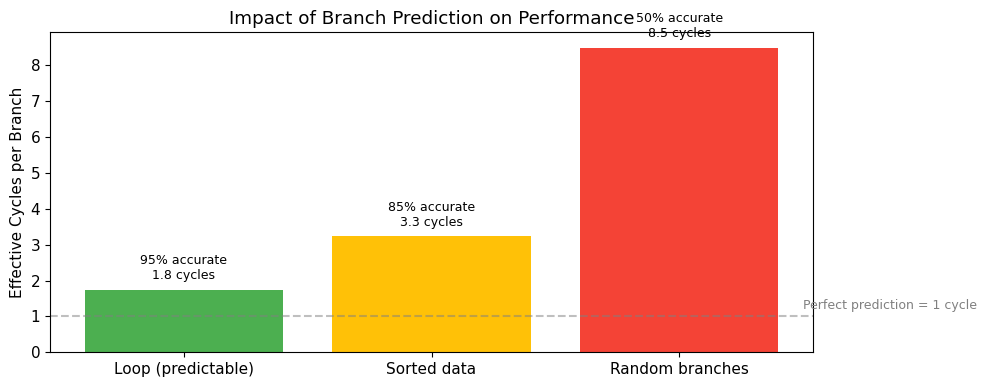

With 50% accuracy, each branch effectively costs 8.5 cycles instead of 1!


In [36]:
# | export
# Visualize branch prediction impact
fig, ax = plt.subplots(figsize=(10, 4))

scenarios = ['Loop (predictable)', 'Sorted data', 'Random branches']
accuracies = [95, 85, 50]  # Typical prediction accuracies
penalty_cycles = 15  # Typical misprediction penalty

# Calculate effective cycles per branch
effective_cycles = [1 + (1 - acc/100) * penalty_cycles for acc in accuracies]

x = range(len(scenarios))
bars = ax.bar(x, effective_cycles, color=['#4CAF50', '#FFC107', '#F44336'])

ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.set_ylabel('Effective Cycles per Branch')
ax.set_title('Impact of Branch Prediction on Performance')

# Add labels
for bar, acc, eff in zip(bars, accuracies, effective_cycles):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{acc}% accurate\n{eff:.1f} cycles', ha='center', va='bottom', fontsize=9)

ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.text(2.5, 1.2, 'Perfect prediction = 1 cycle', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print("With 50% accuracy, each branch effectively costs 8.5 cycles instead of 1!")

### Looking Ahead: Why This Matters for Parallelism

Branches are one of the biggest obstacles to parallelism. If the CPU doesn't know which path to take, it can't run instructions in parallel along that path.

This is why:
- GPUs prefer "SIMD" (Same Instruction, Multiple Data) without branches
- Vectorized code avoids branches when possible
- "Branchless" programming is a real optimization technique

**Practical connection: Why NumPy is fast**

Remember our ALU that does one operation at a time? Modern CPUs have special **SIMD** hardware that acts like an ALU processing 4, 8, or even 16 numbers simultaneously with a single instruction.

When you write `numpy.array([1,2,3,4]) + numpy.array([5,6,7,8])`, NumPy uses SIMD to add all four pairs in roughly the time it takes to add one pair. This is why:

```python
# Slow: Python loop with branches and individual operations
for i in range(len(a)):
    result[i] = a[i] + b[i]

# Fast: NumPy uses SIMD - one instruction, multiple data
result = a + b
```

The lesson: contiguous data + no branches + SIMD = fast. This is the foundation of high-performance numerical computing.

We'll explore this more when we look at GPU architecture and parallelism.

## Summary: Your Mental Model of a CPU

You now have the building blocks to understand what happens when you run code:

**1. Logic Gates are the atoms**
- AND, OR, NOT, XOR combine to build everything
- XOR + AND gives us binary addition

**2. The ALU does math**
- Built from gates
- Takes an opcode to select the operation
- Addition happens by chaining full adders

**3. Cycles are discrete time**
- Each operation takes a fixed number of cycles
- Multiplication costs more than addition
- Memory access costs WAY more than computation

**4. Memory is a hierarchy**
- Registers: tiny, instant
- Cache: small, fast (automatic)
- RAM: big, slow
- The cache saves you when you access the same data repeatedly

**5. Load/Store moves data**
- Data must travel from memory to registers to be computed on
- Memory access is usually the bottleneck, not computation

**6. Branches break predictability**
- if/else and loops are just jumps in the instruction stream
- Unpredictable branches hurt performance
- This matters a lot for parallelism (GPUs, vectorization)

In [37]:
# Final practice: trace through a simple program

# This program computes factorial(4) = 4 * 3 * 2 * 1 = 24
factorial_program = [
    ('LOAD_IMM', 0, 4),          # 0: R0 = 4 (counter)
    ('LOAD_IMM', 1, 1),          # 1: R1 = 1 (result accumulator)
    ('LOAD_IMM', 2, 1),          # 2: R2 = 1 (for decrementing)
    # Loop: R1 = R1 * R0, R0 = R0 - 1, repeat while R0 > 0
    # (We'll fake multiply as repeated addition for this simple CPU)
    # Actually, let's just trace it conceptually
]

print("Mental exercise: trace factorial(4)")
print("")
print("Initial: R0=4 (counter), R1=1 (result)")
print("Loop iterations:")
print("  1: R1 = 1 * 4 = 4,  R0 = 4 - 1 = 3")
print("  2: R1 = 4 * 3 = 12, R0 = 3 - 1 = 2")
print("  3: R1 = 12 * 2 = 24, R0 = 2 - 1 = 1")
print("  4: R1 = 24 * 1 = 24, R0 = 1 - 1 = 0")
print("  (R0 = 0, exit loop)")
print("")
print(f"Result: 4! = 24")

# Verify
test_factorial_result = 4 * 3 * 2 * 1
assert test_factorial_result == 24, "Factorial check failed"
print("Factorial verified!")

Mental exercise: trace factorial(4)

Initial: R0=4 (counter), R1=1 (result)
Loop iterations:
  1: R1 = 1 * 4 = 4,  R0 = 4 - 1 = 3
  2: R1 = 4 * 3 = 12, R0 = 3 - 1 = 2
  3: R1 = 12 * 2 = 24, R0 = 2 - 1 = 1
  4: R1 = 24 * 1 = 24, R0 = 1 - 1 = 0
  (R0 = 0, exit loop)

Result: 4! = 24
Factorial verified!


## Next Steps

Now that you understand CPU fundamentals, here are natural follow-up topics:

1. **GPU Architecture**: How GPUs differ from CPUs (massive parallelism, different memory model)

2. **SIMD and Vectorization**: How modern CPUs process multiple data elements in parallel

3. **Memory Access Patterns**: Why array layout matters (row-major vs column-major, cache lines)

4. **Assembly Language**: Reading real machine code to understand what your compiler generates

5. **Parallelism**: Threads, synchronization, and why shared memory is hard